# Comparative of supevised learning methods for relational data

## Import and setting

In [1]:
! pip install umap-learn

In [2]:
! pip install datashader bokeh holoviews scikit-image colorcet

In [3]:
# Classification Project: Sonar rocks or mines

# Load libraries
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

# dimension reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA # ne supporte pas la sparcité
from sklearn.decomposition import IncrementalPCA

import umap
import umap.plot
from sklearn.manifold import TSNE # manifold learning

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier # XGBoost

import numpy as np

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


# Relational dataset

In [7]:
from pathlib import Path
import scipy.io
import numpy as np
mat = scipy.io.loadmat(Path.cwd().parent.parent/'Donnees_relationnelles'/'cora.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'W', 'fea', 'gnd'])

In [8]:
# get data
X = np.array(mat.get('fea'))
W = np.array(mat.get('W'))
y = np.array(mat.get('gnd'))

In [9]:
X.shape, W.shape, y.shape

((2708, 1433), (2708, 2708), (2708, 1))

In [8]:
import pandas as pd
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns=['label'])  # Assuming 'label' is the name of the column

# Concatenate X and y along the columns (axis=1)
df = pd.concat([X_df, y_df], axis=1)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


# Exploration et visualisation des données

In [9]:
# nombre
from collections import Counter

def target2counts(df_doc: pd.DataFrame) -> {str: int}:
    """
    Count number of document per label
    :param df_doc:
    :return:
    """
    targets = list(df_doc.label)
    target_counter = Counter(targets)  # -> dico
    return target_counter

target2counts(df)

Counter({4: 818, 5: 426, 1: 351, 3: 418, 2: 217, 6: 298, 7: 180})

In [10]:
# nombre de classes
set(np.unique(y))

{1, 2, 3, 4, 5, 6, 7}

In [11]:
# le taux de sparsicité
from numpy import count_nonzero

nb_nonZero = count_nonzero(X)
my_size = float(X.size)
print("Nombre d'éléments non nuls : ", nb_nonZero)
print("Nombre d'éléments : ", my_size)
print("Sparsité : ", 1-(nb_nonZero/my_size))

Nombre d'éléments non nuls :  49216
Nombre d'éléments :  3880564.0
Sparsité :  0.9873173074841698


### LSA (aka TruncatedSVD)

In [12]:
# la dimension fitté par le modèle
lsa = TruncatedSVD()
lsa.fit(X)
cumsum = np.cumsum(lsa.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals XXX
d

1

la matrice étant très sparce, il ne faut qu'1 seul dimension, on va essayer de confirmer ce résulat via le graphique en coude

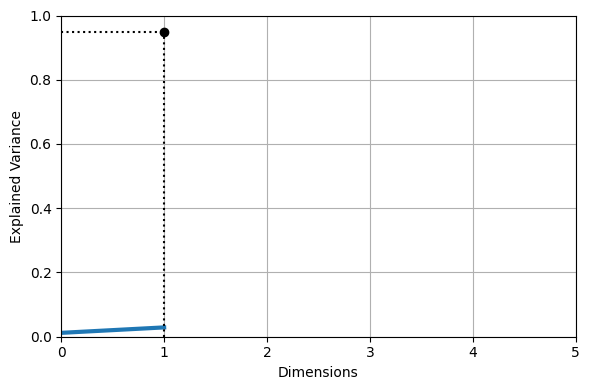

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 5, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(10, 0.1), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig(f"{DOCUMENT_NAME}_LSA_explained_variance_plot")
plt.show()

 -> vers une approche ICPA

Etant donné que l'on a une matrice très sparse, nous allons explorer une autre approche de PCA qui nous permettra de faire en même temps du PCA, de l'imputation. En d'autre terme, nous ferons une imputation à l'aide du PCA


### Incremental PCA

In [14]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
inc_pca = IncrementalPCA()
inc_pca.fit(X)
inc_pca_ckcumsum = np.cumsum(inc_pca.explained_variance_ratio_)
inc_pca_ck_d = np.argmax(inc_pca_ckcumsum >= 0.95) + 1
inc_pca_ck_d

802

Confirmons notre intuition à partir d'un graphique


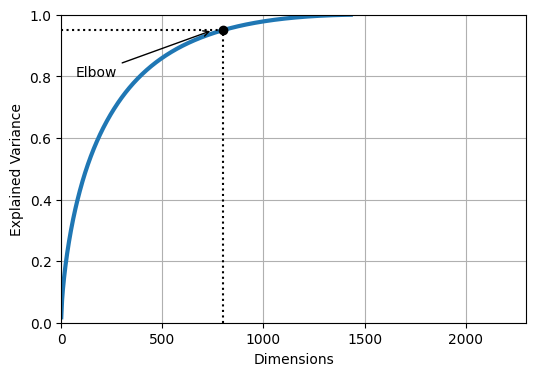

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(inc_pca_ckcumsum, linewidth=3)
plt.axis([0, 2300, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([inc_pca_ck_d, inc_pca_ck_d], [0, 0.95], "k:")
plt.plot([0, inc_pca_ck_d], [0.95, 0.95], "k:")
plt.plot(inc_pca_ck_d, 0.95, "ko")
plt.annotate("Elbow", xy=(750, 0.95), xytext=(70, 0.8),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [16]:
# refaisons la projection
inc_pca_new = IncrementalPCA(
    n_components=inc_pca_ck_d,
    batch_size=1500
)
X_inc_pca = inc_pca_new.fit_transform(X)
print('X_docs_tfidf_red_inc_pca_new: ', X_inc_pca.shape)

X_docs_tfidf_red_inc_pca_new:  (2708, 802)


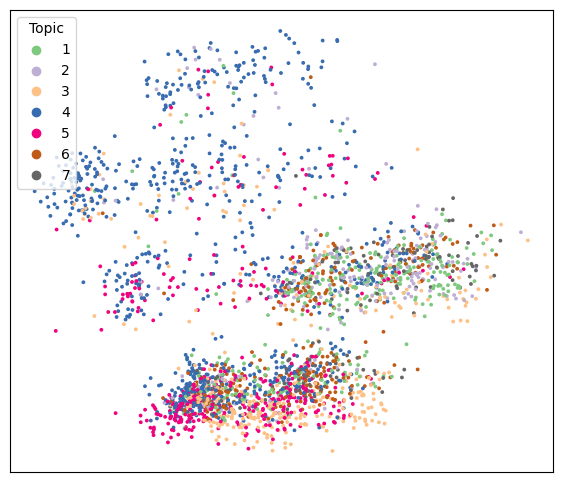

In [17]:
fig, ax = plt.subplots(figsize=(7, 6))

classes = ["1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7"]
scatter = ax.scatter(
    x=X_inc_pca[:, 0],
    y=X_inc_pca[:, 1],
    c=y,
    cmap='Accent',
    s=3,
    alpha=1
)
handles, labels = scatter.legend_elements()
labels = np.unique(y)
ax.legend(handles, labels, loc="upper left", title="Topic")
plt.setp(ax, xticks=[], yticks=[])
#ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using \n Multidimensional scaling \n', size=16)
#save_fig("bbc_W2V_MultiSCALING_plot")
plt.show()

### TSNE

In [18]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    n_iter=300,
    random_state=1,
)
X_tsne = t_sne.fit_transform(X)

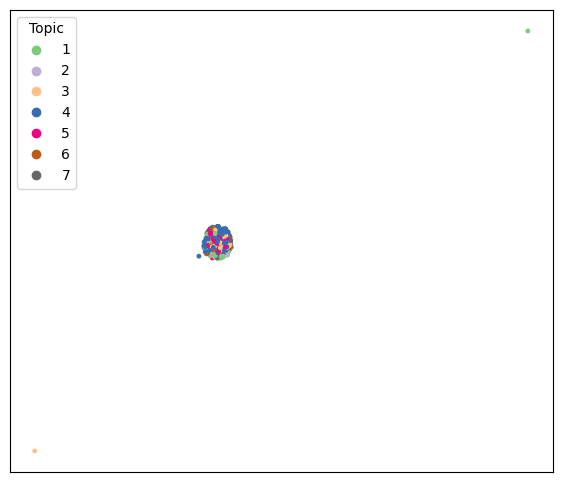

In [19]:
fig, ax = plt.subplots(figsize=(7, 6))

classes = ["1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7"]
scatter = ax.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    c=y,
    cmap='Accent',
    s=6,
    alpha=1
)
handles, labels = scatter.legend_elements()
labels = np.unique(y)
ax.legend(handles, labels, loc="upper left", title="Topic")
plt.setp(ax, xticks=[], yticks=[])
#ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using \n Multidimensional scaling \n', size=16)
#save_fig("bbc_W2V_MultiSCALING_plot")
plt.show()

TSNE ne semble pas donner une bonne representation de nos documents.
nous allons utiliser la methode UMAP

## UMAP

In [20]:
mapper = umap.UMAP(metric='hellinger').fit(X)

<Axes: >

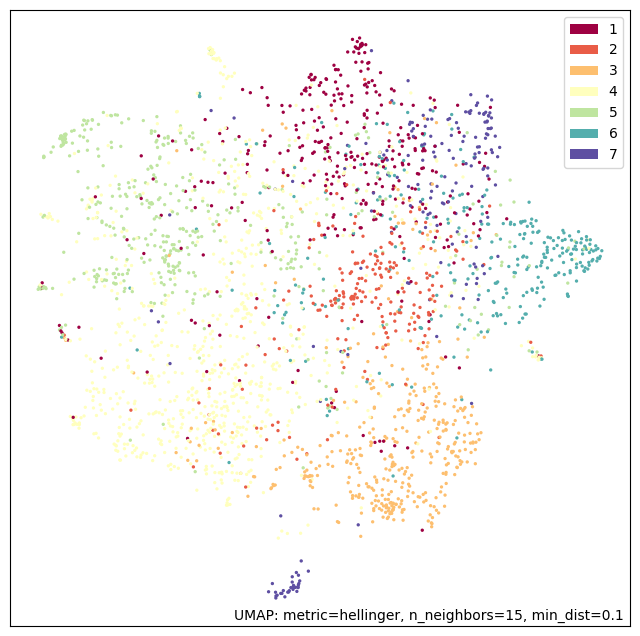

In [21]:
umap.plot.points(mapper, labels=y.ravel())

# Application de méthodes de classification sur les données de l'espace initial

### Echantillionnage des données en train et test

In [22]:
from sklearn.model_selection import train_test_split

# Stratifier la division en tenant compte des classes déséquilibrées
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print(f"X_train shape: {X_train.shape}\n")
print(f"X_test shape: {X_test.shape}\n")
print(f"y_train shape: {y_train.shape}\n")
print(f"y_test shape: {y_test.shape}\n")
X_train, y_train

X_train shape: (2166, 1433)

X_test shape: (542, 1433)

y_train shape: (2166, 1)

y_test shape: (542, 1)


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[3],
        [4],
        [5],
        ...,
        [7],
        [6],
        [6]], dtype=uint8))

In [23]:
from collections import Counter

counter = Counter(y_train.ravel())
counter

Counter({3: 334, 4: 654, 5: 341, 6: 238, 1: 281, 7: 144, 2: 174})

### Application des algorithme supervisés

In [24]:
# Spot Check Algorithms
models = []

### Logistic regression
---

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
X_train_scaled

array([[-0.08065715, -0.10805918, -0.16439899, ..., -0.04301324,
        -0.15837557, -0.06088626],
       [-0.08065715, -0.10805918, -0.16439899, ..., -0.04301324,
        -0.15837557, -0.06088626],
       [-0.08065715, -0.10805918, -0.16439899, ..., -0.04301324,
        -0.15837557, -0.06088626],
       ...,
       [-0.08065715, -0.10805918, -0.16439899, ..., -0.04301324,
        -0.15837557, -0.06088626],
       [-0.08065715, -0.10805918, -0.16439899, ..., -0.04301324,
        -0.15837557, -0.06088626],
       [-0.08065715, -0.10805918, -0.16439899, ..., -0.04301324,
        -0.15837557, -0.06088626]])

In [27]:
model = LogisticRegression(multi_class='multinomial')
solvers = ['newton-cg', 'lbfgs']  # Excluding 'liblinear'
penalty = ['l2']
c_values = [10, 1.0, 0.01]
# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_scaled, y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store best mmodels
models.append(('LRG', LogisticRegression(multi_class='multinomial', **grid_result.best_params_)))
models

Best: 0.744687 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.703140 (0.009962) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.703140 (0.009962) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.710525 (0.013148) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.710525 (0.013148) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.744687 (0.017979) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.744687 (0.017979) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg'))]

### Ridge classifier

In [28]:
# define models and parameters
model = RidgeClassifier()
alpha = [1e-3, 1e-2, 1e-1, 1]
solver=["sparse_cg"]
# define grid search
grid = dict(alpha=alpha, solver=solver)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score='raise')
grid_result = grid_search.fit(X_train_scaled, y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

models.append(('RGC', RidgeClassifier(**grid_result.best_params_)))
models

Best: 0.468591 using {'alpha': 1, 'solver': 'sparse_cg'}
0.464435 (0.021022) with: {'alpha': 0.001, 'solver': 'sparse_cg'}
0.464435 (0.021022) with: {'alpha': 0.01, 'solver': 'sparse_cg'}
0.465821 (0.020314) with: {'alpha': 0.1, 'solver': 'sparse_cg'}
0.468591 (0.021768) with: {'alpha': 1, 'solver': 'sparse_cg'}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(alpha=1, solver='sparse_cg'))]

### KNN

In [29]:
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 32, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_scaled, y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

models.append(('KNN', KNeighborsClassifier(**grid_result.best_params_)))
models

Best: 0.438603 using {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
0.415517 (0.030065) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.415517 (0.030065) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.339802 (0.021107) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.423365 (0.025470) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.359188 (0.040580) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.405360 (0.044474) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.349931 (0.048270) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.405807 (0.050198) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.347167 (0.059666) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.385033 (0.058117) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.312548 

[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(alpha=1, solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', weights='distance'))]

### SVM

In [30]:
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [0.1, 1.0]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_scaled, y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

models.append(('SVM', SVC(**grid_result.best_params_)))
models

Best: 0.712837 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.301939 (0.000896) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.301939 (0.000896) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.302401 (0.001487) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.318560 (0.002936) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.626957 (0.017848) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.712837 (0.017398) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(alpha=1, solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', weights='distance')),
 ('SVM', SVC(kernel='sigmoid'))]

### Bagging Classifier

In [31]:
# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 100]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score='raise')
grid_result = grid_search.fit(X_train , y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

models.append(('BGC', BaggingClassifier(**grid_result.best_params_)))
models

Best: 0.706356 using {'n_estimators': 100}
0.692041 (0.031836) with: {'n_estimators': 10}
0.706356 (0.021273) with: {'n_estimators': 100}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(alpha=1, solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=100))]

### RandomForestClassifier

In [32]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 50]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_scaled, y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

models.append(('RFC', RandomForestClassifier(**grid_result.best_params_)))
models

Best: 0.747918 using {'max_features': 'sqrt', 'n_estimators': 50}
0.702208 (0.024528) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.747918 (0.016096) with: {'max_features': 'sqrt', 'n_estimators': 50}
0.636643 (0.023692) with: {'max_features': 'log2', 'n_estimators': 10}
0.733151 (0.016065) with: {'max_features': 'log2', 'n_estimators': 50}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(alpha=1, solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=100)),
 ('RFC', RandomForestClassifier(n_estimators=50))]

### GradientBoostingClassifier

In [33]:
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10]
learning_rate = [0.1, 0.01]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_scaled, y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

models.append(('GBC', GradientBoostingClassifier(**grid_result.best_params_)))
models

Best: 0.712827 using {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.7}
0.651425 (0.012821) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.650039 (0.009561) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.653730 (0.015593) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.695746 (0.020087) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.5}
0.712827 (0.012786) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.7}
0.695287 (0.018871) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 10, 'subsample': 1.0}
0.694826 (0.016806) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.5}
0.708675 (0.014868) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.7}
0.692053 (0.016280) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators

[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(alpha=1, solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=100)),
 ('RFC', RandomForestClassifier(n_estimators=50)),
 ('GBC',
  GradientBoostingClassifier(max_depth=7, n_estimators=10, subsample=0.7))]

### LDA

In [34]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = StratifiedKFold(n_splits=5)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr']
# grid['shrinkage'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1, error_score=0)
# perform the search
results = search.fit(X_train_scaled, y_train.ravel())
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

models.append(('LDA', LinearDiscriminantAnalysis(**results.best_params_)))
models

Mean Accuracy: 0.448
Config: {'solver': 'lsqr'}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(alpha=1, solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=100)),
 ('RFC', RandomForestClassifier(n_estimators=50)),
 ('GBC',
  GradientBoostingClassifier(max_depth=7, n_estimators=10, subsample=0.7)),
 ('LDA', LinearDiscriminantAnalysis(solver='lsqr'))]

###  DecisionTreeClassifier

In [35]:
# define model
model = DecisionTreeClassifier()
# define model evaluation method
cv = StratifiedKFold(n_splits=5)
grid = dict()
# define grid
grid['min_samples_split'] = range(2, 5)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train_scaled, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

models.append(('DTC', DecisionTreeClassifier(**results.best_params_)))
models

Mean Accuracy: 0.649
Config: {'min_samples_split': 2}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(alpha=1, solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=100)),
 ('RFC', RandomForestClassifier(n_estimators=50)),
 ('GBC',
  GradientBoostingClassifier(max_depth=7, n_estimators=10, subsample=0.7)),
 ('LDA', LinearDiscriminantAnalysis(solver='lsqr')),
 ('DTC', DecisionTreeClassifier())]

### XGB

In [36]:
estimator = XGBClassifier(objective= 'multi:softmax', num_class=7)

parameters = {
    'max_depth': range (1, 10, 5),
    'n_estimators': range(1, 10),
    'learning_rate': [0.1, 0.01]
}
cv = StratifiedKFold(n_splits=5)
search = GridSearchCV(estimator=estimator,
                      param_grid=parameters,
                      scoring = 'accuracy', n_jobs=-1, cv = cv,
                      verbose=True)
# perform the search
grid_result = search.fit(X_train_scaled, y_train.reshape(-1)-1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

models.append(('XGB', XGBClassifier(**grid_result.best_params_)))
models

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best: 0.700818 using {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 9}
0.543391 (0.014463) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1}
0.543391 (0.014463) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 2}
0.542468 (0.013244) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 3}
0.542468 (0.013874) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 4}
0.546163 (0.015299) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 5}
0.553086 (0.011913) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 6}
0.554008 (0.012562) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 7}
0.551703 (0.009389) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 8}
0.558165 (0.009733) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 9}
0.684657 (0.024375) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1}
0.686048 (0.020417)

[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(alpha=1, solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=100)),
 ('RFC', RandomForestClassifier(n_estimators=50)),
 ('GBC',
  GradientBoostingClassifier(max_depth=7, n_estimators=10, subsample=0.7)),
 ('LDA', LinearDiscriminantAnalysis(solver='lsqr')),
 ('DTC', DecisionTreeClassifier()),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None

#### Evaluate algorithm

In [37]:
# Evaluate Algorithms

# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds)
	y_temp = y_test.ravel()
	if name == 'XGB':
		y_temp = y_test.reshape(-1) - 1
	cv_results = cross_val_score(model, X_test_scaled, y_temp, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LRG: 0.629091 (0.074188)
RGC: 0.505320 (0.067698)
KNN: 0.324512 (0.081448)
SVM: 0.533131 (0.061128)
BGC: 0.636431 (0.049841)
RFC: 0.651347 (0.052123)
GBC: 0.655084 (0.047847)
LDA: 0.129125 (0.023126)
DTC: 0.561010 (0.063071)
XGB: 0.619966 (0.034753)


In [38]:
df_results = pd.DataFrame(data=results,index=names)
df_results

,0,1,2,3,4,5,6,7,8,9
LRG,0.563636,0.727273,0.611111,0.555556,0.574074,0.574074,0.592593,0.703704,0.777778,0.611111
RGC,0.490909,0.636364,0.500000,0.388889,0.444444,0.537037,0.481481,0.462963,0.592593,0.518519
KNN,0.381818,0.381818,0.203704,0.407407,0.222222,0.333333,0.240741,0.370370,0.444444,0.259259
SVM,0.490909,0.618182,0.462963,0.481481,0.500000,0.518519,0.481481,0.592593,0.648148,0.537037
BGC,0.581818,0.745455,0.629630,0.611111,0.629630,0.611111,0.629630,0.648148,0.703704,0.574074
RFC,0.600000,0.672727,0.611111,0.611111,0.611111,0.722222,0.574074,0.703704,0.703704,0.703704
GBC,0.563636,0.690909,0.648148,0.592593,0.629630,0.666667,0.666667,0.740741,0.685185,0.666667
LDA,0.109091,0.163636,0.129630,0.129630,0.148148,0.111111,0.111111,0.166667,0.129630,0.092593
DTC,0.436364,0.618182,0.592593,0.518519,0.648148,0.611111,0.481481,0.574074,0.537037,0.592593
XGB,0.600000,0.618182,0.592593,0.611111,0.629630,0.555556,0.685185,0.666667,0.611111,0.629630


Maintenant nous allons visualiser les performances des modeles sur les données de tests

In [39]:
df_results.max(axis=1)

LRG    0.777778
RGC    0.636364
KNN    0.444444
SVM    0.648148
BGC    0.745455
RFC    0.722222
GBC    0.740741
LDA    0.166667
DTC    0.648148
XGB    0.685185
dtype: float64

####  Algorithm boxplot

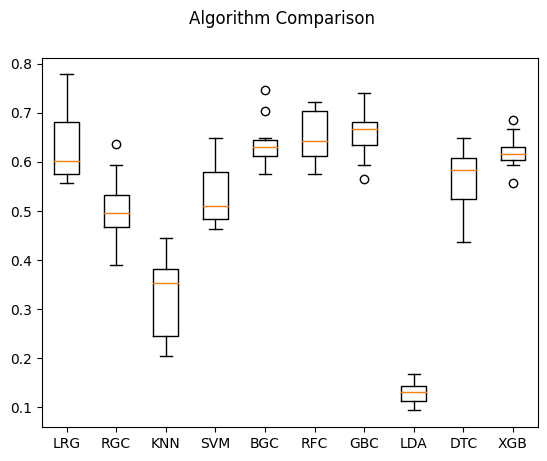

In [40]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Nous pouvons remarquer que les modèles ```LDA``` et ```KNN``` ne performe pas bien. La **Regression Logistic** donne un bon ```accuracy``` sur les données de test et donc semble représenter le bon modèle. Cependant, cette mesure pourrait être biaisé compte tenu du déséquilibre des classes.

Nous allons donc pour surmonter le déséquilibre des classes, effectuer une méthode d'échantillonnage de données (**Oversampling et Undersampling**). D'après les expériences réalisées l'application de simultanée des deux méthodes démontre de bonne performances.  

### Handle unbalanced data

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# y_train
# y_test

over = SMOTE()
under = RandomUnderSampler()

# scale

steps = [('o', over), ('u', under)]
pipeline = ImbPipeline(steps=steps)

# transform the dataset
X_sm, y_sm = pipeline.fit_resample(X_train_scaled, y_train)

X_sm_scaled = scaler.fit_transform(X_sm)
X_sm_scaled.shape, y_sm.shape, Counter(y_sm)

((4578, 1433),
 (4578,),
 Counter({1: 654, 2: 654, 3: 654, 4: 654, 5: 654, 6: 654, 7: 654}))

In [42]:
sm_models = []

In [43]:
model = LogisticRegression(multi_class='multinomial')
solvers = ['newton-cg', 'lbfgs']  # Excluding 'liblinear'
penalty = ['l2']
c_values = [10, 1.0, 0.01]
# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_sm_scaled, y_sm.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store best mmodels
sm_models.append(('LRG', LogisticRegression(multi_class='multinomial', **grid_result.best_params_)))
sm_models

Best: 0.929013 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.923990 (0.010565) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.923990 (0.010565) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.925956 (0.010873) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.925956 (0.010873) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.929013 (0.011618) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.929013 (0.011618) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg'))]

### RGC

In [44]:
# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 1.0]
solver=["sparse_cg"]
# define grid search
grid = dict(alpha=alpha, solver=solver)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sm_scaled, y_sm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# save best estimator
sm_models.append(('RGC', RidgeClassifier(**grid_result.best_params_)))
sm_models

Best: 0.841862 using {'alpha': 1.0, 'solver': 'sparse_cg'}
0.841425 (0.020942) with: {'alpha': 0.1, 'solver': 'sparse_cg'}
0.841862 (0.020668) with: {'alpha': 1.0, 'solver': 'sparse_cg'}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg'))]

### KNN

In [45]:
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sm_scaled, y_sm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

sm_models.append(('KNN', KNeighborsClassifier(**grid_result.best_params_)))
sm_models

Best: 0.851249 using {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
0.839892 (0.012416) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.839892 (0.012416) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.777205 (0.022405) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.818925 (0.017735) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.747058 (0.017955) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.797516 (0.016258) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.719533 (0.021059) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.784629 (0.016977) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.692886 (0.024085) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.766500 (0.022836) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.672135 (

[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=1))]

### SVC

In [46]:
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [1.0, 5.0, 10.0]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sm_scaled, y_sm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

sm_models.append(('SVM', SVC(**grid_result.best_params_)))
sm_models

Best: 0.903462 using {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.465906 (0.044258) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.878128 (0.030311) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.901925 (0.014059) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.504131 (0.037379) with: {'C': 5.0, 'gamma': 'scale', 'kernel': 'poly'}
0.902153 (0.024324) with: {'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.889255 (0.008887) with: {'C': 5.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.534276 (0.040429) with: {'C': 10.0, 'gamma': 'scale', 'kernel': 'poly'}
0.903462 (0.021542) with: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.884887 (0.009453) with: {'C': 10.0, 'gamma': 'scale', 'kernel': 'sigmoid'}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=1)),
 ('SVM', SVC(C=10.0))]

### BGC

In [47]:
# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 20, 50]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sm_scaled, y_sm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

sm_models.append(('BGC', BaggingClassifier(**grid_result.best_params_)))
sm_models

Best: 0.850814 using {'n_estimators': 50}
0.839238 (0.027717) with: {'n_estimators': 10}
0.847977 (0.027105) with: {'n_estimators': 20}
0.850814 (0.021961) with: {'n_estimators': 50}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=1)),
 ('SVM', SVC(C=10.0)),
 ('BGC', BaggingClassifier(n_estimators=50))]

### RFC

In [48]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sm_scaled, y_sm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

sm_models.append(('RFC', RandomForestClassifier(**grid_result.best_params_)))
sm_models

Best: 0.937100 using {'max_features': 'log2', 'n_estimators': 100}
0.875497 (0.018226) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.913070 (0.018429) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.863919 (0.017605) with: {'max_features': 'log2', 'n_estimators': 10}
0.937100 (0.018693) with: {'max_features': 'log2', 'n_estimators': 100}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=1)),
 ('SVM', SVC(C=10.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier(max_features='log2'))]

### GBC

In [49]:
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10]
learning_rate = [0.1, 0.01]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sm_scaled, y_sm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

sm_models.append(('GBC', GradientBoostingClassifier(**grid_result.best_params_)))
sm_models

Best: 0.864142 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.7}
0.787463 (0.015212) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.783754 (0.029332) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.788780 (0.022726) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.854967 (0.020988) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.5}
0.853439 (0.023009) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.7}
0.846011 (0.024162) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 10, 'subsample': 1.0}
0.860430 (0.027369) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.5}
0.864142 (0.023999) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.7}
0.844264 (0.025870) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators

[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=1)),
 ('SVM', SVC(C=10.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier(max_features='log2')),
 ('GBC',
  GradientBoostingClassifier(max_depth=9, n_estimators=10, subsample=0.7))]

### LDA

In [50]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = StratifiedKFold(n_splits=5)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr']
# grid['shrinkage'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1, error_score=0)
# perform the search
results = search.fit(X_sm_scaled, y_sm)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

sm_models.append(('LDA', LinearDiscriminantAnalysis(**results.best_params_)))
sm_models

Mean Accuracy: 0.838
Config: {'solver': 'svd'}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=1)),
 ('SVM', SVC(C=10.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier(max_features='log2')),
 ('GBC',
  GradientBoostingClassifier(max_depth=9, n_estimators=10, subsample=0.7)),
 ('LDA', LinearDiscriminantAnalysis())]

### DTC

In [51]:
# define model
model = DecisionTreeClassifier()
# define model evaluation method
cv = StratifiedKFold(n_splits=5)
grid = dict()
# define grid
grid['min_samples_split'] = range(2, 5)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_sm_scaled, y_sm)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

sm_models.append(('DTC', DecisionTreeClassifier(**results.best_params_)))
sm_models

Mean Accuracy: 0.802
Config: {'min_samples_split': 2}


[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=1)),
 ('SVM', SVC(C=10.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier(max_features='log2')),
 ('GBC',
  GradientBoostingClassifier(max_depth=9, n_estimators=10, subsample=0.7)),
 ('LDA', LinearDiscriminantAnalysis()),
 ('DTC', DecisionTreeClassifier())]

### XGB

In [52]:
estimator = XGBClassifier(objective= 'multi:softmax', num_class=7)

parameters = {
    'max_depth': range (1, 10, 5),
    'n_estimators': range(1, 10),
    'learning_rate': [0.1, 0.01]
}
cv = StratifiedKFold(n_splits=5)
search = GridSearchCV(estimator=estimator,
                      param_grid=parameters,
                      scoring = 'accuracy', n_jobs=-1, cv = cv,
                      verbose=True)
# perform the search
grid_result = search.fit(X_sm_scaled, y_sm.reshape(-1)-1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

sm_models.append(('XGB', XGBClassifier(**grid_result.best_params_)))
sm_models

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.827661 using {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 9}
0.536044 (0.013441) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1}
0.545001 (0.016783) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 2}
0.577108 (0.015367) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 3}
0.593712 (0.020726) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 4}
0.601136 (0.020731) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 5}
0.607040 (0.020924) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 6}
0.617961 (0.018082) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 7}
0.613593 (0.020676) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 8}
0.623421 (0.013121) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 9}
0.761908 (0.021666) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1}
0.782659 (0.025426) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 

[('LRG',
  LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=1)),
 ('SVM', SVC(C=10.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier(max_features='log2')),
 ('GBC',
  GradientBoostingClassifier(max_depth=9, n_estimators=10, subsample=0.7)),
 ('LDA', LinearDiscriminantAnalysis()),
 ('DTC', DecisionTreeClassifier()),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
        

### Evaluation sm model

In [53]:
# Evaluate Algorithms

# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

sm_results = []
sm_names = []
for name, model in sm_models:
	kfold = KFold(n_splits=num_folds)
	y_temp = y_test.reshape(-1)
	if name == 'XGB':
		y_temp = y_test.reshape(-1) - 1
	cv_results = cross_val_score(model, X_test_scaled, y_temp, cv=kfold, scoring=scoring)
	sm_results.append(cv_results)
	sm_names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LRG: 0.629091 (0.074188)
RGC: 0.505320 (0.067698)
KNN: 0.206195 (0.079051)
SVM: 0.486970 (0.064766)
BGC: 0.623603 (0.039728)
RFC: 0.640236 (0.078170)
GBC: 0.642155 (0.041368)
LDA: 0.304512 (0.039604)
DTC: 0.559226 (0.064297)
XGB: 0.619966 (0.034753)


In [54]:
df_sm_results = pd.DataFrame(data=sm_results,index=sm_names)
df_sm_results

,0,1,2,3,4,5,6,7,8,9
LRG,0.563636,0.727273,0.611111,0.555556,0.574074,0.574074,0.592593,0.703704,0.777778,0.611111
RGC,0.490909,0.636364,0.500000,0.388889,0.444444,0.537037,0.481481,0.462963,0.592593,0.518519
KNN,0.381818,0.272727,0.129630,0.259259,0.092593,0.222222,0.166667,0.148148,0.203704,0.185185
SVM,0.490909,0.545455,0.407407,0.481481,0.407407,0.462963,0.407407,0.574074,0.592593,0.500000
BGC,0.581818,0.672727,0.611111,0.592593,0.666667,0.611111,0.555556,0.629630,0.685185,0.629630
RFC,0.545455,0.727273,0.537037,0.611111,0.629630,0.759259,0.537037,0.666667,0.722222,0.666667
GBC,0.581818,0.654545,0.666667,0.592593,0.629630,0.592593,0.648148,0.722222,0.666667,0.666667
LDA,0.272727,0.290909,0.351852,0.277778,0.314815,0.314815,0.351852,0.296296,0.222222,0.351852
DTC,0.454545,0.563636,0.592593,0.500000,0.611111,0.666667,0.462963,0.592593,0.555556,0.592593
XGB,0.600000,0.618182,0.592593,0.611111,0.629630,0.555556,0.685185,0.666667,0.611111,0.629630


In [55]:
df_sm_results.max(axis=1)

LRG    0.777778
RGC    0.636364
KNN    0.381818
SVM    0.592593
BGC    0.685185
RFC    0.759259
GBC    0.722222
LDA    0.351852
DTC    0.666667
XGB    0.685185
dtype: float64

###  Algorithm boxplot

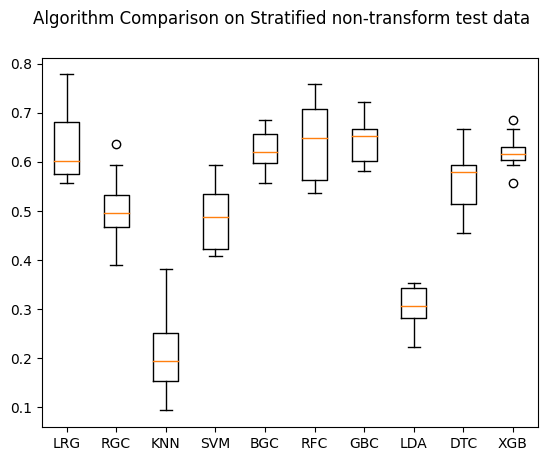

In [56]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison on Stratified non-transform test data')
ax = fig.add_subplot(111)
plt.boxplot(sm_results)
ax.set_xticklabels(sm_names)
plt.show()

Nous pouvons remarquer que la méthode améliore les performances des modèles. Même le KNN et LDA se voient leur performance améliorés même s'il demeurent assez bas comparé au autres modèles.

Les résultats montrent que la **Régression Logistic** donne une bonne accuracy qui représente maintenant une bonne métrique car on a pris en considération de ```déséquilibre des classes```.

The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, then evaluate the model on the stratified but non-transformed test set.

## Considering X = D^(-1)*W*X

In [57]:
from numpy.linalg import inv

In [58]:
# Calculate X

# D: D est une matrice diagonale, chaque valeur diagonale correspond à la somme des valeurs d’une ligne de W
W_row_sum = W.sum(axis=1)
# W_row_sum

D = np.diag(W_row_sum)
X_ = np.dot(np.dot(inv(D), W), X)

# X_.shape
W_ = np.array(mat.get('W'))
y_ = np.array(mat.get('gnd'))

In [59]:
X_.shape, W_.shape, y_.shape

((2708, 1433), (2708, 2708), (2708, 1))

In [60]:
# visualisation

<Axes: >

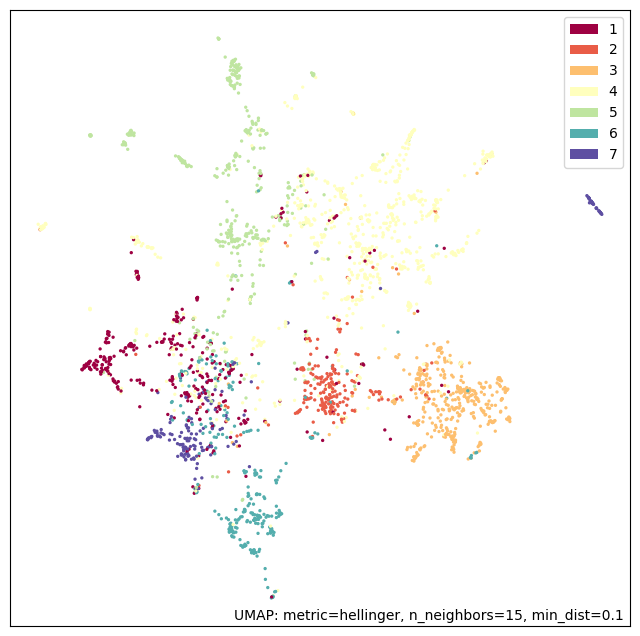

In [61]:
mapper = umap.UMAP(metric='hellinger').fit(X_)
umap.plot.points(mapper, labels=y_.ravel())

In [98]:
Nous obtenons une meilleur visualisation des données encombinants les informations
sur les liens entre les documents

SyntaxError: ignored

In [62]:
# create dataframe with nex X

import pandas as pd
X_df_ = pd.DataFrame(X_)
y_df_ = pd.DataFrame(y, columns=['label'])  # Assuming 'label' is the name of the column

# Concatenate X and y along the columns (axis=1)
df_ = pd.concat([X_df_, y_df_], axis=1)
df_.head()

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,4
1,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,5
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,5
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
4,0.0,0.2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4


In [63]:
# Spot Check Algorithms
_models = []

### Echantillionnage des données en train et test

In [64]:

from sklearn.model_selection import train_test_split

# Stratifier la division en tenant compte des classes déséquilibrées
_X_train, _X_test, _y_train, _y_test = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {_X_train.shape}\n")
print(f"X_train shape: {_X_test.shape}\n")
print(f"X_train shape: {_y_train.shape}\n")
print(f"X_train shape: {_y_test.shape}\n")

X_train shape: (2166, 1433)

X_train shape: (542, 1433)

X_train shape: (2166, 1)

X_train shape: (542, 1)


In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
_X_train_scaled = scaler.fit_transform(_X_train)
_X_test_scaled = scaler.transform(_X_test)

### LogisticRegression

In [66]:
model = LogisticRegression(multi_class='multinomial')
solvers = ['newton-cg']  # Excluding 'liblinear'
penalty = ['l2']
c_values = [10, 1.0]
# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(_X_train_scaled, _y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store best mmodels
_models.append(('LRG', LogisticRegression(multi_class='multinomial', **grid_result.best_params_)))

Best: 0.801474 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794548 (0.023678) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.801474 (0.024984) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [67]:
_models

[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg'))]

### RidgeClassifier

In [68]:
# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 1.0]
solver=["sparse_cg"]
# define grid search
grid = dict(alpha=alpha, solver=solver)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_train_scaled, _y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_models.append(('RGC', RidgeClassifier(**grid_result.best_params_)))

Best: 0.623718 using {'alpha': 1.0, 'solver': 'sparse_cg'}
0.577559 (0.009041) with: {'alpha': 0.1, 'solver': 'sparse_cg'}
0.623718 (0.015589) with: {'alpha': 1.0, 'solver': 'sparse_cg'}


In [69]:
_models

[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg'))]

### KNeighborsClassifier

In [70]:
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(5, 10)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_train_scaled, _y_train.reshape(-1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_models.append(('KNN', KNeighborsClassifier(**grid_result.best_params_)))
_models

Best: 0.731760 using {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
0.695285 (0.010783) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.731759 (0.010483) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.696205 (0.013070) with: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
0.731760 (0.007044) with: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
0.692977 (0.014124) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.725291 (0.018306) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.689745 (0.013643) with: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}
0.723449 (0.015140) with: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
0.682824 (0.022726) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.722988 (0.020019) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.569260 

[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN',
  KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance'))]

### SVC

In [71]:
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [1.0, 5.0, 10.0]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_train_scaled, _y_train.reshape(-1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_models.append(('SVM', SVC(**grid_result.best_params_)))
_models

Best: 0.826861 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.386427 (0.010615) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.771008 (0.022055) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.826861 (0.020040) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.522616 (0.022304) with: {'C': 5.0, 'gamma': 'scale', 'kernel': 'poly'}
0.784402 (0.025429) with: {'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.795930 (0.024346) with: {'C': 5.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.576631 (0.029346) with: {'C': 10.0, 'gamma': 'scale', 'kernel': 'poly'}
0.784404 (0.024292) with: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.771462 (0.018608) with: {'C': 10.0, 'gamma': 'scale', 'kernel': 'sigmoid'}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN',
  KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')),
 ('SVM', SVC(kernel='sigmoid'))]

### BaggingClassifier

In [72]:
# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 20, 50]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_train_scaled, _y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_models.append(('BGC', BaggingClassifier(**grid_result.best_params_)))
_models

Best: 0.782552 using {'n_estimators': 50}
0.776545 (0.023769) with: {'n_estimators': 10}
0.781625 (0.014050) with: {'n_estimators': 20}
0.782552 (0.011917) with: {'n_estimators': 50}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN',
  KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=50))]

### RandomForestClassifier

In [73]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_train_scaled, _y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_models.append(('RFC', RandomForestClassifier(**grid_result.best_params_)))
_models

Best: 0.828255 using {'max_features': 'sqrt', 'n_estimators': 100}
0.782537 (0.013810) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.828255 (0.010584) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.744226 (0.011605) with: {'max_features': 'log2', 'n_estimators': 10}
0.819485 (0.012572) with: {'max_features': 'log2', 'n_estimators': 100}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN',
  KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier())]

### GradientBoostingClassifier

In [74]:
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10]
learning_rate = [0.001, 0.01]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_train_scaled, _y_train.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_models.append(('GBC', GradientBoostingClassifier(**grid_result.best_params_)))
_models

Best: 0.301939 using {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.301939 (0.000896) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.301939 (0.000896) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.301939 (0.000896) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.301939 (0.000896) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.5}
0.301939 (0.000896) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.7}
0.301939 (0.000896) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 10, 'subsample': 1.0}
0.301939 (0.000896) with: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.5}
0.301939 (0.000896) with: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.7}
0.301939 (0.000896) with: {'learning_rate': 0.001, 'max_dept

[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN',
  KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier()),
 ('GBC',
  GradientBoostingClassifier(learning_rate=0.001, n_estimators=10, subsample=0.5))]

### LinearDiscriminantAnalysis

In [75]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = StratifiedKFold(n_splits=5)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr']
# grid['shrinkage'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1, error_score=0)
# perform the search
results = search.fit(_X_train_scaled, _y_train.ravel())
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

_models.append(('LDA', LinearDiscriminantAnalysis(**results.best_params_)))
_models

Mean Accuracy: 0.569
Config: {'solver': 'lsqr'}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN',
  KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier()),
 ('GBC',
  GradientBoostingClassifier(learning_rate=0.001, n_estimators=10, subsample=0.5)),
 ('LDA', LinearDiscriminantAnalysis(solver='lsqr'))]

### DecisionTreeClassifier

In [76]:
# define model
model = DecisionTreeClassifier()
# define model evaluation method
cv = StratifiedKFold(n_splits=5)
grid = dict()
# define grid
grid['min_samples_split'] = range(2, 5)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(_X_train_scaled, _y_train.ravel())
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

_models.append(('DTC', DecisionTreeClassifier(**results.best_params_)))
_models

Mean Accuracy: 0.715
Config: {'min_samples_split': 3}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN',
  KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier()),
 ('GBC',
  GradientBoostingClassifier(learning_rate=0.001, n_estimators=10, subsample=0.5)),
 ('LDA', LinearDiscriminantAnalysis(solver='lsqr')),
 ('DTC', DecisionTreeClassifier(min_samples_split=3))]

In [77]:
estimator = XGBClassifier(objective= 'multi:softmax', num_class=7)

parameters = {
    'max_depth': range (1, 10, 5),
    'n_estimators': range(1, 10),
    'learning_rate': [0.1, 0.01]
}
cv = StratifiedKFold(n_splits=5)
search = GridSearchCV(estimator=estimator,
                      param_grid=parameters,
                      scoring = 'accuracy', n_jobs=-1, cv = cv,
                      verbose=True)
# perform the search
grid_result = search.fit(_X_train_scaled, _y_train.reshape(-1)-1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_models.append(('XGB', XGBClassifier(**grid_result.best_params_)))
_models

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.784398 using {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 9}
0.631583 (0.025425) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1}
0.651428 (0.026496) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 2}
0.660662 (0.019417) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 3}
0.668509 (0.025079) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 4}
0.678209 (0.025064) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 5}
0.676359 (0.028139) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 6}
0.672666 (0.022008) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 7}
0.672665 (0.021083) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 8}
0.677280 (0.022578) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 9}
0.741923 (0.011942) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1}
0.764079 (0.014819) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 

[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN',
  KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')),
 ('SVM', SVC(kernel='sigmoid')),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier()),
 ('GBC',
  GradientBoostingClassifier(learning_rate=0.001, n_estimators=10, subsample=0.5)),
 ('LDA', LinearDiscriminantAnalysis(solver='lsqr')),
 ('DTC', DecisionTreeClassifier(min_samples_split=3)),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_thres

### Evaluation _ model

In [78]:
# Evaluate Algorithms

# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

_results = []
_names = []
for name, model in sm_models:
	kfold = KFold(n_splits=num_folds)
	y_temp = _y_test.reshape(-1)
	if name == 'XGB':
		y_temp = _y_test.reshape(-1) - 1
	cv_results = cross_val_score(model, _X_test_scaled, y_temp, cv=kfold, scoring=scoring)
	_results.append(cv_results)
	_names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LRG: 0.789596 (0.040986)
RGC: 0.734478 (0.062344)
KNN: 0.394882 (0.044307)
SVM: 0.719394 (0.055745)
BGC: 0.730572 (0.083337)
RFC: 0.752626 (0.062493)
GBC: 0.695556 (0.052111)
LDA: 0.481347 (0.106478)
DTC: 0.638586 (0.057330)
XGB: 0.706599 (0.067102)


In [79]:
_df_results = pd.DataFrame(data=_results, index=_names)
_df_results

,0,1,2,3,4,5,6,7,8,9
LRG,0.781818,0.836364,0.814815,0.722222,0.740741,0.796296,0.870370,0.777778,0.777778,0.777778
RGC,0.690909,0.690909,0.796296,0.629630,0.703704,0.851852,0.796296,0.722222,0.759259,0.703704
KNN,0.381818,0.381818,0.481481,0.388889,0.462963,0.351852,0.351852,0.370370,0.425926,0.351852
SVM,0.690909,0.836364,0.703704,0.629630,0.703704,0.703704,0.703704,0.796296,0.740741,0.685185
BGC,0.636364,0.854545,0.722222,0.685185,0.814815,0.740741,0.629630,0.814815,0.796296,0.611111
RFC,0.690909,0.890909,0.722222,0.648148,0.777778,0.759259,0.722222,0.796296,0.740741,0.777778
GBC,0.618182,0.781818,0.685185,0.722222,0.703704,0.722222,0.611111,0.759259,0.685185,0.666667
LDA,0.454545,0.618182,0.592593,0.537037,0.481481,0.388889,0.240741,0.574074,0.500000,0.425926
DTC,0.509091,0.654545,0.648148,0.611111,0.685185,0.648148,0.648148,0.740741,0.648148,0.592593
XGB,0.618182,0.818182,0.629630,0.685185,0.722222,0.703704,0.722222,0.722222,0.814815,0.629630


In [80]:
_df_results.max(axis=1)

LRG    0.870370
RGC    0.851852
KNN    0.481481
SVM    0.836364
BGC    0.854545
RFC    0.890909
GBC    0.781818
LDA    0.618182
DTC    0.740741
XGB    0.818182
dtype: float64

### Algorithms boxplot

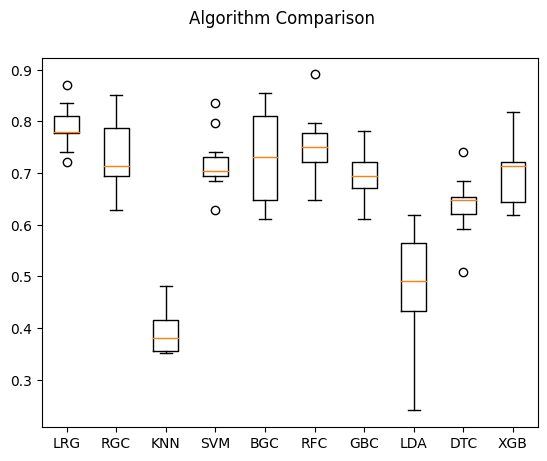

In [81]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(_results)
ax.set_xticklabels(_names)
plt.show()

Nous pouvons remarque une nette amélioration des performances (**accuracy**) des modèles  suer les données de test en l'occurence les modèles ```RandomForest``` (0.89), ```Logisticregrtession```(0.87), ```RidgeClassifier``` (0.85), ```XGBoosting```(0.81). Cela est due au fait que la matrice a été enrichi par les informations des liens entre les documents. Cependant nous avons toujours le problème du déséquilibre
des classes.

Pour cela nous allons effectuer une methode de rééquilibrage des classes afin d'améliorer les performances des modèles

## handle unbalanced data

In [82]:
scaler = StandardScaler()
_X_train_scaled = scaler.fit_transform(_X_train)
_X_test_scaled = scaler.transform(_X_test)
# y_train
# y_test

over = SMOTE()
under = RandomUnderSampler()

# scale

steps = [('o', over), ('u', under)]
pipeline = ImbPipeline(steps=steps)

# transform the dataset
_X_sm, _y_sm = pipeline.fit_resample(_X_train_scaled, _y_train)

X_sm_scaled = scaler.fit_transform(_X_sm)
X_sm_scaled.shape, y_sm.shape, Counter(y_sm)

((4578, 1433),
 (4578,),
 Counter({1: 654, 2: 654, 3: 654, 4: 654, 5: 654, 6: 654, 7: 654}))

In [83]:
_sm_models = []

### Logistic Regression

In [84]:
model = LogisticRegression(multi_class='multinomial')
solvers = ['newton-cg']  # Excluding 'liblinear'
penalty = ['l2']
c_values = [10, 1.0]
# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(_X_sm, _y_sm.reshape(-1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store best mmodels
_sm_models.append(('LRG', LogisticRegression(multi_class='multinomial', **grid_result.best_params_)))

Best: 0.942333 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937747 (0.004568) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.942333 (0.003610) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


### RidgeClassifier

In [85]:
# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 1.0]
solver=["sparse_cg"]
# define grid search
grid = dict(alpha=alpha, solver=solver)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_sm, _y_sm.reshape(-1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_sm_models.append(('RGC', RidgeClassifier(**grid_result.best_params_)))
_sm_models

Best: 0.895154 using {'alpha': 1.0, 'solver': 'sparse_cg'}
0.891440 (0.007165) with: {'alpha': 0.1, 'solver': 'sparse_cg'}
0.895154 (0.007623) with: {'alpha': 1.0, 'solver': 'sparse_cg'}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg'))]

### KNeighborsClassifier

In [86]:
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 32, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_sm, _y_sm.reshape(-1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_sm_models.append(('KNN', KNeighborsClassifier(**grid_result.best_params_)))
_sm_models

Best: 0.915903 using {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.915903 (0.005011) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.915903 (0.005011) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.878770 (0.015925) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.897337 (0.013849) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.855399 (0.019056) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.879644 (0.015492) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.826129 (0.018939) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.864355 (0.017350) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.801885 (0.025516) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.846443 (0.017607) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.781569 (

[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=1))]

## SVM

In [87]:
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [1.0, 5.0, 10.0]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_sm, _y_sm.reshape(-1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_sm_models.append(('SVM', SVC(**grid_result.best_params_)))
_sm_models

Best: 0.935565 using {'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.622101 (0.023383) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.927263 (0.007115) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.916125 (0.008845) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.772162 (0.026104) with: {'C': 5.0, 'gamma': 'scale', 'kernel': 'poly'}
0.935565 (0.010362) with: {'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.908260 (0.009465) with: {'C': 5.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.833327 (0.021501) with: {'C': 10.0, 'gamma': 'scale', 'kernel': 'poly'}
0.935565 (0.009941) with: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.899524 (0.009893) with: {'C': 10.0, 'gamma': 'scale', 'kernel': 'sigmoid'}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=1)),
 ('SVM', SVC(C=5.0))]

## BGC

In [88]:
# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 20, 50]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_sm, _y_sm.reshape(-1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_sm_models.append(('BGC', BaggingClassifier(**grid_result.best_params_)))
_sm_models

Best: 0.903675 using {'n_estimators': 50}
0.892973 (0.016082) with: {'n_estimators': 10}
0.901273 (0.017395) with: {'n_estimators': 20}
0.903675 (0.014510) with: {'n_estimators': 50}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=1)),
 ('SVM', SVC(C=5.0)),
 ('BGC', BaggingClassifier(n_estimators=50))]

### RandomForestClassifier

In [89]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_sm, _y_sm.reshape(-1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_sm_models.append(('RFC', RandomForestClassifier(**grid_result.best_params_)))
_sm_models

Best: 0.929232 using {'max_features': 'sqrt', 'n_estimators': 100}
0.909791 (0.015140) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.929232 (0.015035) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.894280 (0.013050) with: {'max_features': 'log2', 'n_estimators': 10}
0.928577 (0.015808) with: {'max_features': 'log2', 'n_estimators': 100}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=1)),
 ('SVM', SVC(C=5.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier())]

### GradientBoostingClassifier

In [90]:
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10]
learning_rate = [0.001, 0.01]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(_X_sm, _y_sm.reshape(-1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_sm_models.append(('GBC', GradientBoostingClassifier(**grid_result.best_params_)))
_sm_models

Best: 0.893408 using {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.5}
0.801448 (0.023746) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.788342 (0.021137) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.745095 (0.030581) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.879427 (0.021494) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.5}
0.876370 (0.021879) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.7}
0.822198 (0.026492) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 10, 'subsample': 1.0}
0.893408 (0.020540) with: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.5}
0.886418 (0.019774) with: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.7}
0.829841 (0.024658) with: {'learning_rate': 0.001, 'max_dept

[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=1)),
 ('SVM', SVC(C=5.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier()),
 ('GBC',
  GradientBoostingClassifier(learning_rate=0.001, max_depth=9, n_estimators=10,
                             subsample=0.5))]

### LinearDiscriminantAnalysis

In [91]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = StratifiedKFold(n_splits=5)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr']
# grid['shrinkage'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1, error_score=0)
# perform the search
results = search.fit(_X_sm, _y_sm.reshape(-1))
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

_sm_models.append(('LDA', LinearDiscriminantAnalysis(**results.best_params_)))
_sm_models

Mean Accuracy: 0.890
Config: {'solver': 'svd'}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=1)),
 ('SVM', SVC(C=5.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier()),
 ('GBC',
  GradientBoostingClassifier(learning_rate=0.001, max_depth=9, n_estimators=10,
                             subsample=0.5)),
 ('LDA', LinearDiscriminantAnalysis())]

### DecisionTreeClassifier

In [92]:
# define model
model = DecisionTreeClassifier()
# define model evaluation method
cv = StratifiedKFold(n_splits=5)
grid = dict()
# define grid
grid['min_samples_split'] = range(2, 5)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(_X_sm, _y_sm.reshape(-1))
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

_sm_models.append(('DTC', DecisionTreeClassifier(**results.best_params_)))
_sm_models

Mean Accuracy: 0.853
Config: {'min_samples_split': 2}


[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=1)),
 ('SVM', SVC(C=5.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier()),
 ('GBC',
  GradientBoostingClassifier(learning_rate=0.001, max_depth=9, n_estimators=10,
                             subsample=0.5)),
 ('LDA', LinearDiscriminantAnalysis()),
 ('DTC', DecisionTreeClassifier())]

### XGBoostClassifier

In [93]:
estimator = XGBClassifier(objective= 'multi:softmax', num_class=7)

parameters = {
    'max_depth': range (1, 10, 5),
    'n_estimators': range(1, 10),
    'learning_rate': [0.1, 0.01]
}
cv = StratifiedKFold(n_splits=5)
search = GridSearchCV(estimator=estimator,
                      param_grid=parameters,
                      scoring = 'accuracy', n_jobs=-1, cv = cv,
                      verbose=True)
# perform the search
grid_result = search.fit(_X_sm, _y_sm.reshape(-1)-1)
_sm_models.append(('XGB', XGBClassifier(**results.best_params_)))
_sm_models

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

_sm_models.append(('XGB', GradientBoostingClassifier(**grid_result.best_params_)))
_sm_models

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.882706 using {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 9}
0.618180 (0.014357) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1}
0.643078 (0.010049) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 2}
0.657276 (0.011695) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 3}
0.656188 (0.019436) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 4}
0.676717 (0.017773) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 5}
0.685016 (0.013914) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 6}
0.697469 (0.021147) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 7}
0.704896 (0.015837) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 8}
0.708607 (0.014167) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 9}
0.826786 (0.019369) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1}
0.847097 (0.016360) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 

[('LRG', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('RGC', RidgeClassifier(solver='sparse_cg')),
 ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=1)),
 ('SVM', SVC(C=5.0)),
 ('BGC', BaggingClassifier(n_estimators=50)),
 ('RFC', RandomForestClassifier()),
 ('GBC',
  GradientBoostingClassifier(learning_rate=0.001, max_depth=9, n_estimators=10,
                             subsample=0.5)),
 ('LDA', LinearDiscriminantAnalysis()),
 ('DTC', DecisionTreeClassifier()),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_

#### Evaluate Algorithms

In [94]:
# Evaluate Algorithms

# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

_sm_results = []
_sm_names = []
for name, model in sm_models:
	kfold = KFold(n_splits=num_folds)
	y_temp = _y_test.reshape(-1)
	if name == 'XGB':
		y_temp = _y_test.reshape(-1) - 1
	cv_results = cross_val_score(model, _X_test_scaled, y_temp, cv=kfold, scoring=scoring)
	_sm_results.append(cv_results)
	_sm_names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LRG: 0.789596 (0.040986)
RGC: 0.734478 (0.062344)
KNN: 0.394882 (0.044307)
SVM: 0.719394 (0.055745)
BGC: 0.726902 (0.076125)
RFC: 0.734108 (0.054311)
GBC: 0.704747 (0.063751)
LDA: 0.481347 (0.106478)
DTC: 0.651380 (0.068716)
XGB: 0.706599 (0.067102)


In [95]:
_df_sm_results = pd.DataFrame(data=_sm_results, index=_names)
_df_sm_results

,0,1,2,3,4,5,6,7,8,9
LRG,0.781818,0.836364,0.814815,0.722222,0.740741,0.796296,0.870370,0.777778,0.777778,0.777778
RGC,0.690909,0.690909,0.796296,0.629630,0.703704,0.851852,0.796296,0.722222,0.759259,0.703704
KNN,0.381818,0.381818,0.481481,0.388889,0.462963,0.351852,0.351852,0.370370,0.425926,0.351852
SVM,0.690909,0.836364,0.703704,0.629630,0.703704,0.703704,0.703704,0.796296,0.740741,0.685185
BGC,0.618182,0.854545,0.722222,0.703704,0.796296,0.722222,0.666667,0.796296,0.777778,0.611111
RFC,0.727273,0.854545,0.703704,0.629630,0.740741,0.703704,0.740741,0.777778,0.740741,0.722222
GBC,0.618182,0.818182,0.685185,0.611111,0.648148,0.722222,0.759259,0.759259,0.740741,0.685185
LDA,0.454545,0.618182,0.592593,0.537037,0.481481,0.388889,0.240741,0.574074,0.500000,0.425926
DTC,0.509091,0.745455,0.703704,0.611111,0.685185,0.666667,0.666667,0.703704,0.666667,0.555556
XGB,0.618182,0.818182,0.629630,0.685185,0.722222,0.703704,0.722222,0.722222,0.814815,0.629630


In [96]:
_df_sm_results.max(axis=1)

LRG    0.870370
RGC    0.851852
KNN    0.481481
SVM    0.836364
BGC    0.854545
RFC    0.854545
GBC    0.818182
LDA    0.618182
DTC    0.745455
XGB    0.818182
dtype: float64

## Comparison

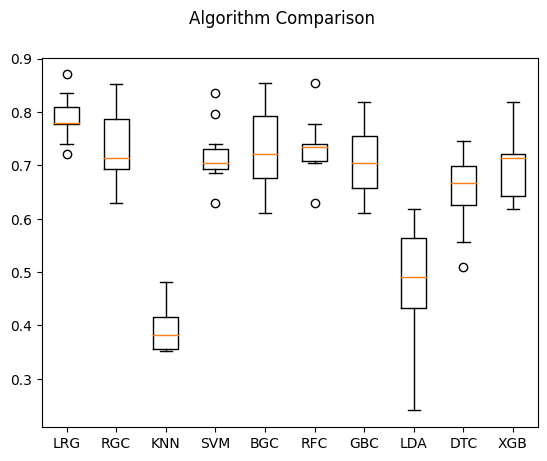

In [97]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(_sm_results)
ax.set_xticklabels(_names)
plt.show()

Nous pouvons remarquer une amélioration de l'accuracy des modèles lorsque l'on règle le problème de déséquilibre des classes. On note également une meilleur performance du modèle **LogisticRegression** (0.87) suivi des modèles ```RidgeClassifier```, ```BagginClassifier``` et ```RandomForest``` qui obtienne une accuracy simmilaire (0.85). Il est aussi à noter que ```LDA``` même s'il n'obtient pas un grande accauracy s'est vu son accurancy augmenté notament du l'enrichissement des données et du ré-échantillonnage. Par contre ```KNN``` reste relativement faible en terme d'accuracy malgré une légére amélioration de son accuracy.

Un hypothèse pour le KNN serait que la métrique de distance utilisé  pour inférer les classes n'est pas adapté à la structure des documents.